# Analysis of the input data
- What is typical customer/fraudster behavior?
- Which type of aggregated information could be useful for the simulator?
- Where are structural differences between fraud/non-fraud?

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
from datetime import datetime, timedelta
import utils_data
from os.path import join
from IPython.display import display

In [2]:
dates_2016 = [datetime(2016, 1, 1) + timedelta(days=i) for i in range(366)]

##### Read in dataset and split into fraud/non-fraud

In [4]:
dataset01, dataset0, dataset1 = utils_data.get_real_dataset()
datasets = [dataset0, dataset1]

out_folder = utils_data.FOLDER_REAL_DATA_ANALYSIS

##### Print some basic info about the dataset

In [5]:
print(dataset01.head())

              Global_Date          Local_Date  CardID  MerchantID  Amount  \
62431 2015-12-31 14:00:25 2016-01-01 00:53:25       0           0   49.00   
62480 2015-12-31 16:26:34 2016-01-01 01:19:34       1           1  148.30   
62481 2015-12-31 18:00:00 2016-01-01 02:53:00       2           1  233.00   
62482 2015-12-31 22:49:00 2016-01-01 07:42:00       3           0    1.00   
62483 2016-01-01 00:19:31 2016-01-01 09:12:31       4           1  187.76   

      Currency Country  Target  
62431      EUR      FR       0  
62480      GBP      NL       0  
62481      EUR      BE       0  
62482      EUR      FR       0  
62483      GBP      DK       0  


In [7]:
data_stats = utils_data.get_real_data_stats()
data_stats.to_csv(join(utils_data.FOLDER_SIMULATOR_INPUT, 'aggregated_data.csv'))
display(data_stats)

,all,non-fraud,fraud
transactions,90357,89194,1163
transactions/hour,10.29,10.15,0.13
transactions/day,246.88,243.7,3.18
transactions/week,1737.63,1715.27,22.37
transactions/month,7529.75,7432.83,96.92
cards,54666,54133,799
"cards, single use",35002,34873,543
"cards, multi use",19664,19260,256
fraud cards in genuine,-,-,0.332916
first transaction,2015-12-31,2015-12-31,2016-03-02


Percentage of fraudulent cards also in genuine transactions:

In [8]:
most_used_card = dataset0['CardID'].value_counts().index[0]
print("Card (ID) with most transactions: ", most_used_card)

Card (ID) with most transactions:  8970


## 1. TIME of TRANSACTION: 
Here we analyse number of transactions regarding time.

### 1.1 Activity per day:

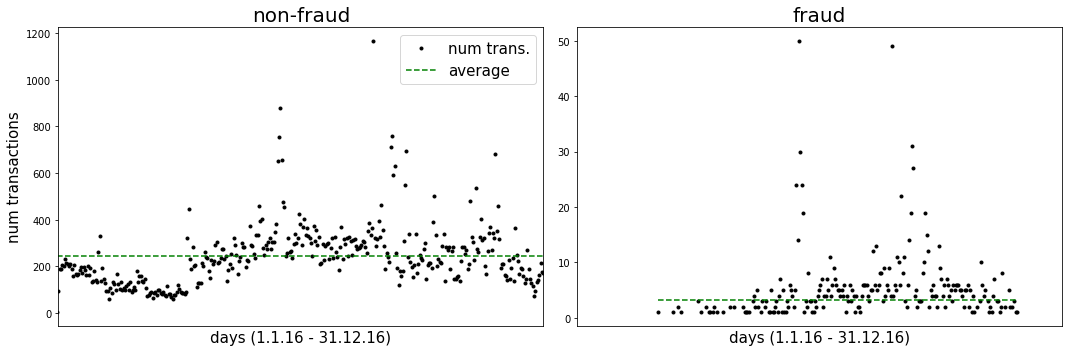

In [9]:
plt.figure(figsize=(15, 5))
plt_idx = 1
for d in datasets:
    plt.subplot(1, 2, plt_idx)
    trans_dates = d["Global_Date"].apply(lambda date: date.date())
    all_trans = trans_dates.value_counts().sort_index()
    date_num = matplotlib.dates.date2num(all_trans.index)
    plt.plot(date_num, all_trans.values, 'k.', label='num trans.')
    plt.plot(date_num, np.zeros(len(date_num))+np.sum(all_trans)/366, 'g--',label='average')
    plt_idx += 1
    plt.title(d.name, size=20)
    plt.xlabel('days (1.1.16 - 31.12.16)', size=15)
    plt.xticks([])
    plt.xlim(matplotlib.dates.date2num([datetime(2016,1,1), datetime(2016,12,31)]))
    if plt_idx == 2:
        plt.ylabel('num transactions', size=15)
        plt.legend(fontsize=15)
plt.tight_layout()
plt.savefig(join(utils_data.FOLDER_REAL_DATA_ANALYSIS, 'time_day-in-year'))
plt.show()

Analysis: 
- It's interesting that there seems to be some kind of structure in the fraudster behavior. I.e., there are many days on which the number of frauds is exactly the same. This must either be due to some peculiarity in the data (are these days where fraud was investigated more?) or because the fraudsters do coordinated attacks

### 1.2 Activity per day in a month:

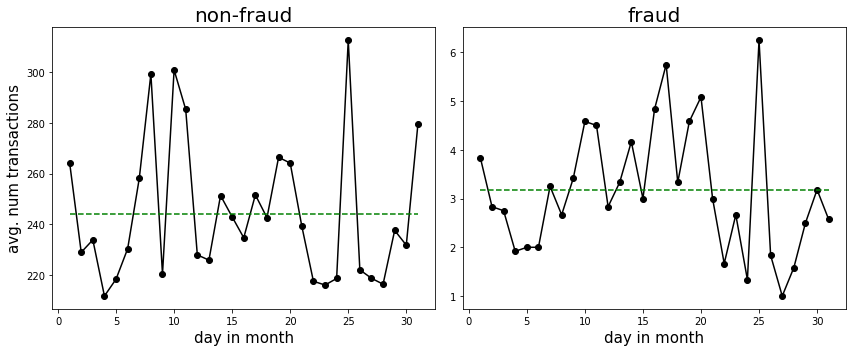

In [10]:
monthdays_2016 = np.unique([dates_2016[i].day for i in range(366)], return_counts=True)
monthdays_2016 = monthdays_2016[1][monthdays_2016[0]-1]

plt.figure(figsize=(12, 5))
plt_idx = 1
monthday_frac = np.zeros((31, 2))
idx = 0
for d in datasets:
    
    # get the average number of transactions per day in a month
    monthday = d["Local_Date"].apply(lambda date: date.day).value_counts().sort_index()
    monthday /= monthdays_2016
    if idx > -1:
        monthday_frac[:, idx] = monthday.values / np.sum(monthday.values, axis=0)
    idx += 1
    
    plt.subplot(1, 2, plt_idx)
    plt.plot(monthday.index, monthday.values, 'ko')
    plt.plot(monthday.index, monthday.values, 'k-', markersize=0.1)
    
    plt.plot(monthday.index, np.zeros(31)+np.sum(monthday)/31, 'g--', label='average')
    plt.title(d.name, size=20)
    plt.xlabel('day in month', size=15)
    if plt_idx == 1:
        plt.ylabel('avg. num transactions', size=15)
    plt_idx += 1
plt.tight_layout()
plt.savefig(join(utils_data.FOLDER_REAL_DATA_ANALYSIS, 'time_day-in-month'))
plt.show()

# save the resulting data
np.save(join(utils_data.FOLDER_SIMULATOR_INPUT, 'monthday_frac'), monthday_frac)

Analysis:
- the amount of transactions does not depend on the day in a month in a utilisable way

### 1.3 Activity per weekday:

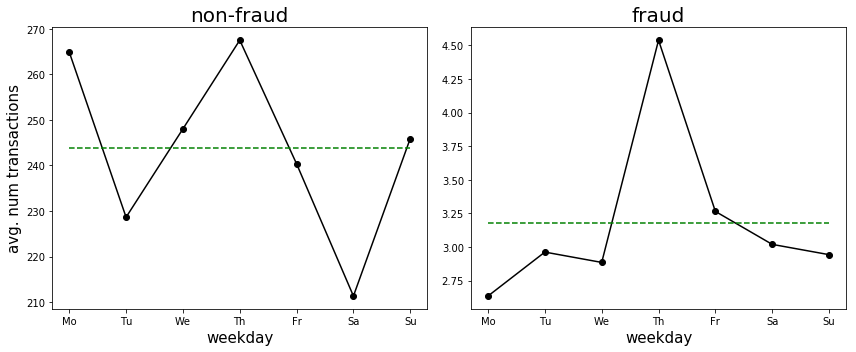

In [11]:
weekdays_2016 = np.unique([dates_2016[i].weekday() for i in range(366)], return_counts=True)
weekdays_2016 = weekdays_2016[1][weekdays_2016[0]]

plt.figure(figsize=(12, 5))
plt_idx = 1
weekday_frac = np.zeros((7, 2))
idx = 0
for d in datasets:
    
    weekday = d["Local_Date"].apply(lambda date: date.weekday()).value_counts().sort_index()
    weekday /= weekdays_2016
    if idx > -1:
        weekday_frac[:, idx] = weekday.values / np.sum(weekday.values, axis=0)
    idx += 1

    plt.subplot(1, 2, plt_idx)
    plt.plot(weekday.index, weekday.values, 'ko')
    plt.plot(weekday.index, weekday.values, 'k-', markersize=0.1)
    plt.plot(weekday.index, np.zeros(7)+np.sum(weekday)/7, 'g--', label='average')
    plt.title(d.name, size=20)
    plt.xlabel('weekday', size=15)
    plt.xticks(range(7), ['Mo', 'Tu', 'We', 'Th', 'Fr', 'Sa', 'Su'])
    if plt_idx == 1:
        plt.ylabel('avg. num transactions', size=15)
    plt_idx += 1
plt.tight_layout()
plt.savefig(join(utils_data.FOLDER_REAL_DATA_ANALYSIS, 'time_day-in-week'))
plt.show()

# save the resulting data
np.save(join(utils_data.FOLDER_SIMULATOR_INPUT, 'weekday_frac'), weekday_frac)

Analysis:
- the amount of transactions does not depend on the day in a week in a utilisable way

### 1.4 Activity per month in a year:

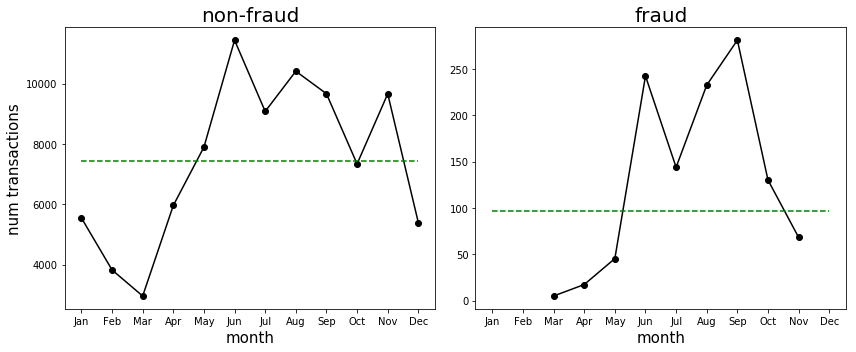

In [12]:
monthdays = np.array([31, 29, 31, 30, 31, 30, 31, 31, 30, 31, 30, 31])

plt.figure(figsize=(12, 5))
plt_idx = 1

month_frac = np.zeros((12, 2))
idx = 0
for d in datasets:
    
    month = d["Local_Date"].apply(lambda date: date.month).value_counts().sort_index()
    # correct for different number of days in a month
    month = month / monthdays[month.index.values-1] * np.mean(monthdays[month.index.values-1])
    
    if idx > -1:
        month_frac[month.index-1, idx] = month.values / np.sum(month.values, axis=0)
    idx += 1
    
    plt.subplot(1, 2, plt_idx)
    plt.plot(month.index, month.values, 'ko')
    plt.plot(month.index, month.values, 'k-', markersize=0.1)
    plt.plot(range(1,13), np.zeros(12)+np.sum(month)/12, 'g--', label='average')
    plt.title(d.name, size=20)
    plt.xlabel('month', size=15)
    plt.xticks(range(1, 13), ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec'])
    if plt_idx == 1:
        plt.ylabel('num transactions', size=15)
    plt_idx += 1
    
plt.tight_layout()
plt.savefig(join(utils_data.FOLDER_REAL_DATA_ANALYSIS, 'time_month-in-year'))
plt.show()

# save the resulting data
np.save(join(utils_data.FOLDER_SIMULATOR_INPUT, 'month_frac'), month_frac)

Analysis:
- people buy more in summer than in winter

### 1.5 Activity per hour of day:

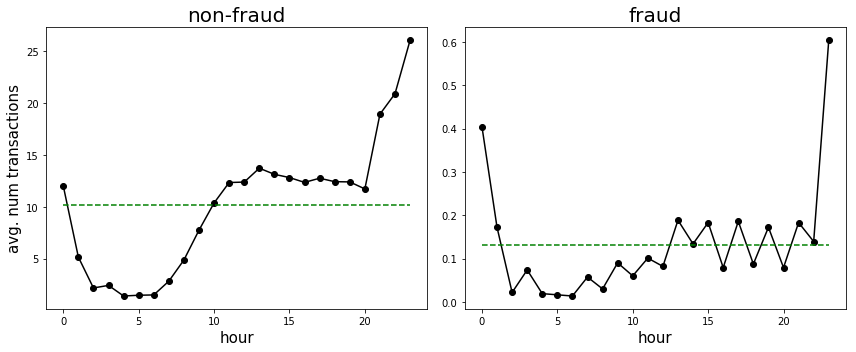

In [13]:
plt.figure(figsize=(12, 5))
plt_idx = 1

hour_frac = np.zeros((24, 2))
idx = 0
for d in datasets:
    
    hours = d["Local_Date"].apply(lambda date: date.hour).value_counts().sort_index()
    hours /= 366
    
    if idx > -1:
        hour_frac[hours.index.values, idx] = hours.values / np.sum(hours.values, axis=0)
    idx += 1
    
    plt.subplot(1, 2, plt_idx)
    plt.plot(hours.index, hours.values, 'ko')
    plt.plot(hours.index, hours.values, 'k-', markersize=0.1, label='transactions')
    plt.plot(range(24), np.zeros(24)+np.sum(hours)/24, 'g--', label='average')
    plt.title(d.name, size=20)
    plt.xlabel('hour', size=15)
    # plt.xticks([])
    if plt_idx == 1:
        plt.ylabel('avg. num transactions', size=15)
    plt_idx += 1
    
plt.tight_layout()
plt.savefig(join(utils_data.FOLDER_REAL_DATA_ANALYSIS, 'time_hour-in-day'))
plt.show()

# save the resulting data
np.save(join(utils_data.FOLDER_SIMULATOR_INPUT, 'hour_frac'), hour_frac)

Analysis:
- the hour of day is very important: people spend most in the evening and least during the night; fraud is usually committed in the night

In [14]:
# extract only hours
date_hour_counts = dataset0["Local_Date"].apply(lambda d: d.replace(minute=0, second=0)).value_counts(sort=False)
hours = np.array(list(map(lambda d: d.hour, list(date_hour_counts.index))))
counts = date_hour_counts.values

hour_mean = np.zeros(24)
hour_min = np.zeros(24)
hour_max = np.zeros(24)
hour_std = np.zeros(24)
for h in range(24):
    hour_mean[h] = np.mean(counts[hours==h])
    hour_min[h] = np.min(counts[hours==h])
    hour_max[h] = np.max(counts[hours==h])
    hour_std[h] = np.std(counts[hours==h])
    
print(np.vstack((range(24), hour_min, hour_max, hour_mean, hour_std)).T)

[[   0.            1.          266.           13.10746269   31.33507554]
 [   1.            1.          235.            6.44178082   16.42041937]
 [   2.            1.           21.            3.25514403    2.43109238]
 [   3.            1.          230.            4.12149533   15.62630796]
 [   4.            1.            9.            2.72580645    1.83017734]
 [   5.            1.           12.            2.6969697     1.9896426 ]
 [   6.            1.            9.            2.27083333    1.49359164]
 [   7.            1.           24.            3.38032787    2.51414488]
 [   8.            1.           32.            5.34234234    3.93985296]
 [   9.            1.           57.            7.91061453    5.37507689]
 [  10.            1.           55.           10.42032967    7.3081111 ]
 [  11.            1.          121.           12.36712329    9.71241339]
 [  12.            1.           78.           12.44505495    9.10438566]
 [  13.            1.          349.           13.75

### 1.6 TEST: Do the above calculated fractions lead to the correct amount of transactions?

In [15]:
# total number of transactions we want in one year
aggregated_data = pd.read_csv(join(utils_data.FOLDER_SIMULATOR_INPUT, 'aggregated_data.csv'), index_col=0)
trans_per_year = np.array(aggregated_data.loc['transactions'].values, dtype=np.float)[1:]

# transactions per day in a month
frac_monthday = np.load(join(utils_data.FOLDER_SIMULATOR_INPUT, 'monthday_frac.npy'))
# transactions per day in a week
frac_weekday = np.load(join(utils_data.FOLDER_SIMULATOR_INPUT, 'weekday_frac.npy'))
# transactions per month in a year
frac_month = np.load(join(utils_data.FOLDER_SIMULATOR_INPUT, 'month_frac.npy'))
# transactions hour in a day
frac_hour = np.load(join(utils_data.FOLDER_SIMULATOR_INPUT, 'hour_frac.npy'))

cust_idx = 0
std_transactions = 1000
num_customers = 200

# get the probability of a transaction in a given hour
curr_date = datetime(2016, 1, 1)
num_trans = 0
for i in range(366*24):
    new_trans = float(trans_per_year[cust_idx])
    new_trans *= frac_month[curr_date.month-1, cust_idx]
    new_trans *= frac_monthday[curr_date.day-1, cust_idx]
    new_trans *= 7 * frac_weekday[curr_date.weekday(), cust_idx]
    new_trans *= frac_hour[curr_date.hour, cust_idx]
    num_trans += new_trans
    curr_date += timedelta(hours=1)
print(curr_date)
print(trans_per_year[cust_idx])
print(num_trans)
print("")

# the difference happens because some months have longer/shorter days. 
# We did not want to scale up the transactions on day 31 because that's unrealistic.

curr_date = datetime(2016, 1, 1)
num_trans = 0
for i in range(366*24):

    for c in range(num_customers):

        # num_trans is the number of transactions the customer will make in this hour
        # we assume that we have enough customers to model that each customer can make max 1 transaction per hour
        cust_trans = float(trans_per_year[cust_idx])
        cust_trans += np.random.normal(0, std_transactions, 1)[0]
        cust_trans /= num_customers
        cust_trans *= frac_month[curr_date.month-1, cust_idx]
        cust_trans *= frac_monthday[curr_date.day-1, cust_idx]
        cust_trans *= 7 * frac_weekday[curr_date.weekday(), cust_idx]
        cust_trans *= frac_hour[curr_date.hour, cust_idx]
        cust_trans += np.random.normal(0, 0.01, 1)[0]
        
        if cust_trans > np.random.uniform(0, 1, 1)[0]:
            num_trans += 1

    curr_date += timedelta(hours=1)

print(curr_date)
print(trans_per_year[cust_idx])
print(num_trans)
print("")

2017-01-01 00:00:00
89194.0
87602.9074604

2017-01-01 00:00:00
89194.0
88359



## 2. COUNTRY 

###  2.1 Country per transaction:

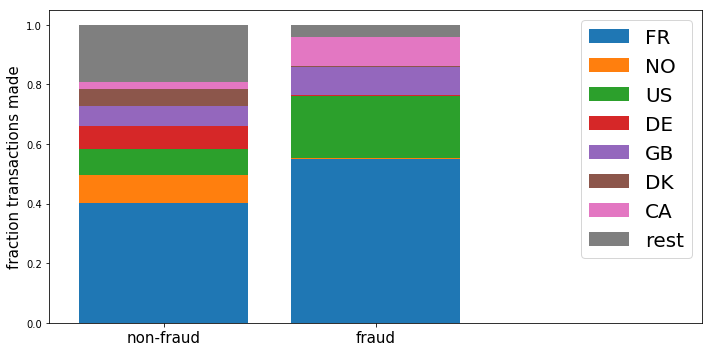

In [16]:
country_counts = pd.concat([d['Country'].value_counts() for d in datasets], axis=1)
country_counts.fillna(0, inplace=True)
country_counts.columns = ['non-fraud', 'fraud']
country_counts[['non-fraud', 'fraud']] /= country_counts.sum(axis=0)

# save the resulting data
country_counts.to_csv(join(utils_data.FOLDER_SIMULATOR_INPUT, 'country_frac.csv'))

countries_large = []
for c in ['non-fraud', 'fraud']:
    countries_large.extend(country_counts.loc[country_counts[c] > 0.05].index)
countries_large = np.unique(countries_large)

countries_large_counts = []
for c in countries_large:
    countries_large_counts.append(country_counts.loc[c, 'non-fraud'])
countries_large = [countries_large[np.argsort(countries_large_counts)[::-1][i]] for i in range(len(countries_large))]

plt.figure(figsize=(10,5))
bottoms = np.zeros(3)
for i in range(len(countries_large)):
    c = countries_large[i]
    plt.bar((0, 1, 2), np.concatenate((country_counts.loc[c], [0])), label=c, bottom=bottoms)
    bottoms += np.concatenate((country_counts.loc[c], [0]))
# fill up the rest
plt.bar((0, 1), 1-bottoms[:-1], bottom=bottoms[:-1], label='rest')
plt.legend(fontsize=20)
plt.xticks([0, 1], ['non-fraud', 'fraud'], size=15)
plt.ylabel('fraction transactions made', size=15)
plt.tight_layout()
plt.savefig(join(utils_data.FOLDER_REAL_DATA_ANALYSIS, 'country_distribution'))
plt.show()

## 3. CURRENCY

### 3.1 Currency per Transaction

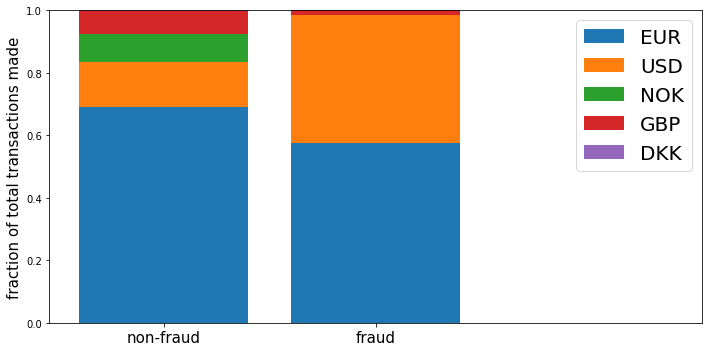

In [17]:
currency_counts = pd.concat([d['Currency'].value_counts() for d in datasets], axis=1)
currency_counts.fillna(0, inplace=True)
currency_counts.columns = ['non-fraud', 'fraud']
currency_counts[['non-fraud', 'fraud']] /= currency_counts.sum(axis=0)

currencies_large = []
for c in ['non-fraud', 'fraud']:
    currencies_large.extend(currency_counts.loc[currency_counts[c] > 0].index)
currencies_large = np.unique(currencies_large)

currencies_large_counts = []
for c in currencies_large:
    currencies_large_counts.append(currency_counts.loc[c, 'non-fraud'])
currencies_large = [currencies_large[np.argsort(currencies_large_counts)[::-1][i]] for i in range(len(currencies_large))]

plt.figure(figsize=(10,5))
bottoms = np.zeros(3)
for i in range(len(currencies_large)):
    c = currencies_large[i]
    plt.bar((0, 1, 2), np.concatenate((currency_counts.loc[c], [0])), label=c, bottom=bottoms)
    bottoms += np.concatenate((currency_counts.loc[c], [0]))
    
plt.legend(fontsize=20)
plt.xticks([0, 1], ['non-fraud', 'fraud'], size=15)
plt.ylabel('fraction of total transactions made', size=15)
plt.tight_layout()
plt.savefig(join(utils_data.FOLDER_REAL_DATA_ANALYSIS, 'currency_distribution'))
plt.show()

### 3.1 Currency per country

Check how many cards make purchases in several currencies:

In [18]:
curr_per_cust = dataset0[['CardID', 'Currency']].groupby('CardID')['Currency'].value_counts().index.get_level_values(0)
print(len(curr_per_cust))
print(len(curr_per_cust.unique()))
print(len(curr_per_cust) - len(curr_per_cust.unique()))

54376
54133
243


CONCLUSION: Only 243 cards out of 54,000 puchased things in several currencies.

Estimate the probability of selection a currency, given a country:

In [19]:
curr_per_country0 = dataset0.groupby(['Country'])['Currency'].value_counts(normalize=True)
curr_per_country1 = dataset1.groupby(['Country'])['Currency'].value_counts(normalize=True)

curr_per_country0.to_csv(join(utils_data.FOLDER_SIMULATOR_INPUT, 'currency_per_country0.csv'))
curr_per_country1.to_csv(join(utils_data.FOLDER_SIMULATOR_INPUT, 'currency_per_country1.csv'))

## 4. Merchants

### 4.1: Merchants per Currency

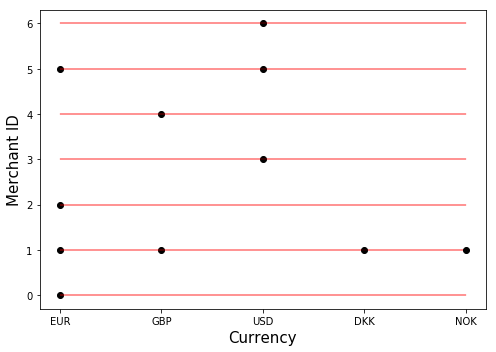

In [20]:
plt.figure(figsize=(7,5))
currencies = dataset01['Currency'].unique()
merchants = dataset01['MerchantID'].unique()
for curr_idx in range(len(currencies)):
    for merch_idx in range(len(merchants)):
        plt.plot(range(len(currencies)), np.zeros(len(currencies))+merch_idx, 'r-', linewidth=0.2)
        if currencies[curr_idx] in dataset01.loc[dataset01['MerchantID'] == merch_idx, 'Currency'].values:
            plt.plot(curr_idx, merch_idx, 'ko')
plt.xticks(range(len(currencies)), currencies)
plt.ylabel('Merchant ID', size=15)
plt.xlabel('Currency', size=15)
plt.tight_layout()
plt.show()
plt.savefig(join(utils_data.FOLDER_REAL_DATA_ANALYSIS, 'currency_per_merchant'))

We conclude from this that most merchants only sell things in one currenyc; thus, we will let each customer select the merchant given the currency that the customer has (which is unique).

Estimate the probability of selection a merchat, given the currency:

In [21]:
merch_per_curr0 = dataset0.groupby(['Currency'])['MerchantID'].value_counts(normalize=True)
merch_per_curr1 = dataset1.groupby(['Currency'])['MerchantID'].value_counts(normalize=True)

merch_per_curr0.to_csv(join(utils_data.FOLDER_SIMULATOR_INPUT, 'merchant_per_currency0.csv'))
merch_per_curr1.to_csv(join(utils_data.FOLDER_SIMULATOR_INPUT, 'merchant_per_currency1.csv'))

### 4.2 Number transactions per merchant

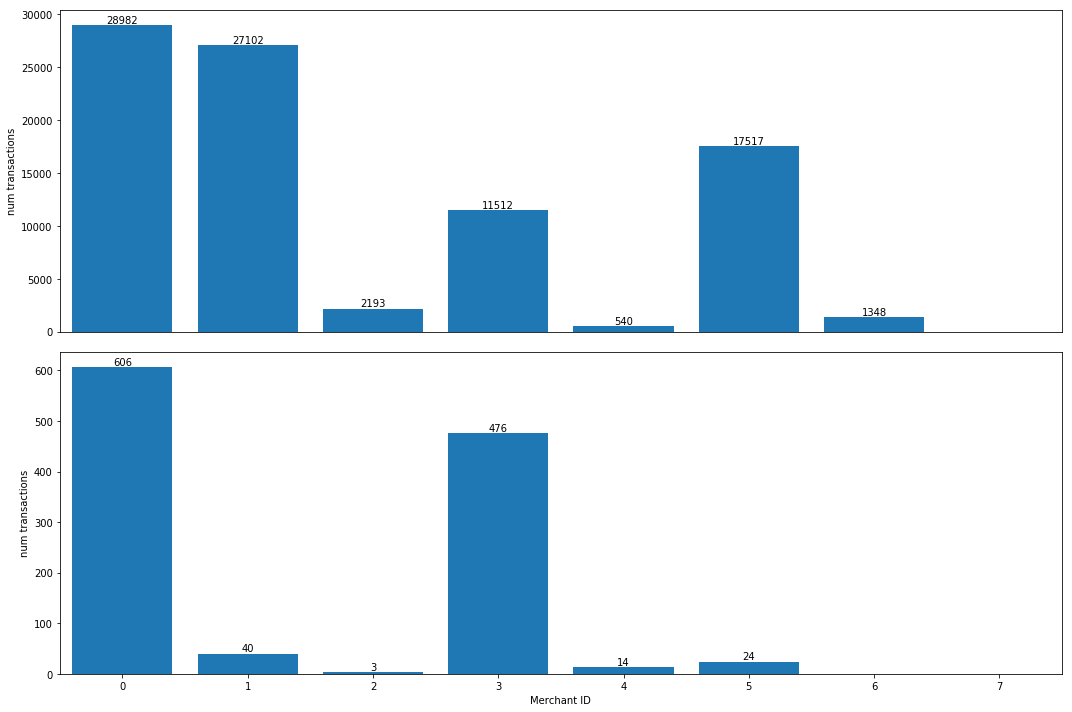

In [22]:
merchant_count0 = dataset0['MerchantID'].value_counts().sort_index()
merchant_count1 = dataset1['MerchantID'].value_counts().sort_index()

plt.figure(figsize=(15,10))

ax = plt.subplot(2, 1, 1)
ax.bar(merchant_count0.index.values, merchant_count0.values)
rects = ax.patches
for rect, label in zip(rects, merchant_count0.values):
    height = rect.get_height()
    ax.text(rect.get_x() + rect.get_width()/2, height, label, ha='center', va='bottom')
plt.ylabel('num transactions')
plt.xticks([])
plt.xlim([-0.5, data_stats.loc['num merchants', 'all']+0.5])

ax = plt.subplot(2, 1, 2)
ax.bar(merchant_count1.index.values, merchant_count1.values)
rects = ax.patches
for rect, label in zip(rects, merchant_count1.values):
    height = rect.get_height()
    ax.text(rect.get_x() + rect.get_width()/2, height, label, ha='center', va='bottom')
plt.ylabel('num transactions')
plt.xlabel('Merchant ID')
plt.xlim([-0.5, data_stats.loc['num merchants', 'all']+0.5])

plt.tight_layout()
plt.show()

## 5. Transaction Amount

### 5.1 Amount over time

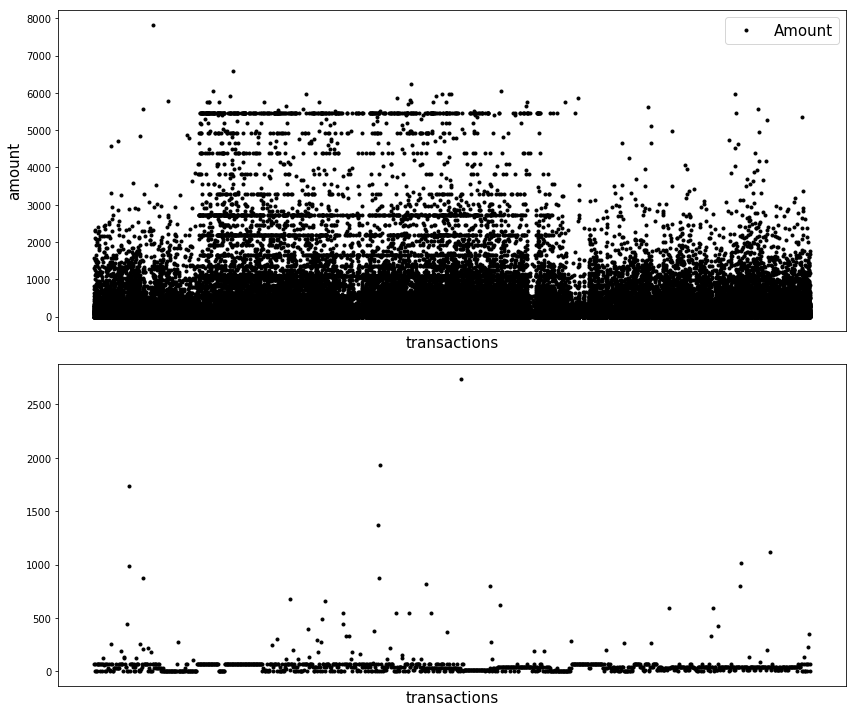

In [23]:
plt.figure(figsize=(12, 10))
plt_idx = 1
for d in datasets:
    plt.subplot(2, 1, plt_idx)
    plt.plot(range(d.shape[0]), d['Amount'], 'k.')
#     plt.plot(date_num, amount, 'k.', label='num trans.')
#     plt.plot(date_num, np.zeros(len(date_num))+np.mean(all_trans), 'g',label='average')
    plt_idx += 1
#     plt.title(d.name, size=20)
    plt.xlabel('transactions', size=15)
    plt.xticks([])
    if plt_idx == 2:
        plt.ylabel('amount', size=15)
        plt.legend(fontsize=15)
plt.tight_layout()
plt.savefig(join(utils_data.FOLDER_REAL_DATA_ANALYSIS, 'amount_day-in-year'))
plt.show()

In [24]:
print(dataset0.loc[dataset0['Amount'] == 5472.53,['Local_Date', 'CardID', 'MerchantID', 'Amount', 'Currency', 'Country']])

               Local_Date  CardID  MerchantID   Amount Currency Country
75714 2016-04-08 09:35:48    9131           5  5472.53      EUR      NL
75718 2016-04-08 09:42:38    9134           5  5472.53      EUR      DE
75889 2016-04-08 15:18:58    9269           5  5472.53      EUR      DE
75920 2016-04-08 17:14:48    9289           5  5472.53      EUR      CY
75933 2016-04-08 16:41:33    9297           5  5472.53      EUR      DE
75951 2016-04-08 12:46:26    9306           5  5472.53      EUR      CA
75953 2016-04-08 16:22:41    9225           5  5472.53      EUR      GB
75967 2016-04-08 18:11:39    9318           5  5472.53      EUR      DE
76030 2016-04-08 19:18:31    9225           5  5472.53      EUR      GB
76090 2016-04-08 22:34:37    9421           5  5472.53      EUR      GB
76155 2016-04-09 07:47:31    9446           5  5472.53      EUR      DE
76184 2016-04-09 10:17:36    9225           5  5472.53      EUR      GB
76231 2016-04-09 14:02:16    9225           5  5472.53      EUR 

### 5.2 Amount distribution

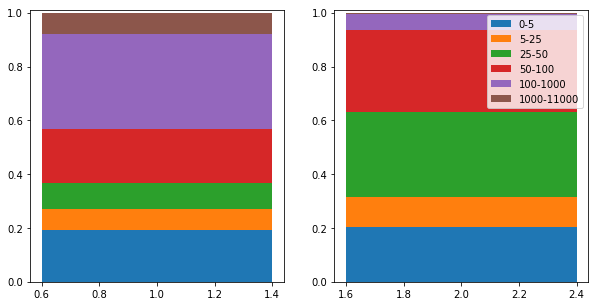

In [25]:
plt.figure(figsize=(10,5))
bins = [0, 5, 25, 50, 100, 1000, 11000]
plt_idx = 1
for d in datasets:
    amount_counts, loc = np.histogram(d["Amount"], bins=bins)
    amount_counts = np.array(amount_counts, dtype=np.float)
    amount_counts /= np.sum(amount_counts)
    plt.subplot(1, 2, plt_idx)
    am_bot = 0
    for i in range(len(amount_counts)):
        plt.bar(plt_idx, amount_counts[i], bottom=am_bot, label='{}-{}'.format(bins[i], bins[i+1]))
        am_bot += amount_counts[i]
    plt_idx += 1
    plt.ylim([0, 1.01])
plt.legend()
# plt.title("Amount distribution")
plt_idx += 1
plt.show()

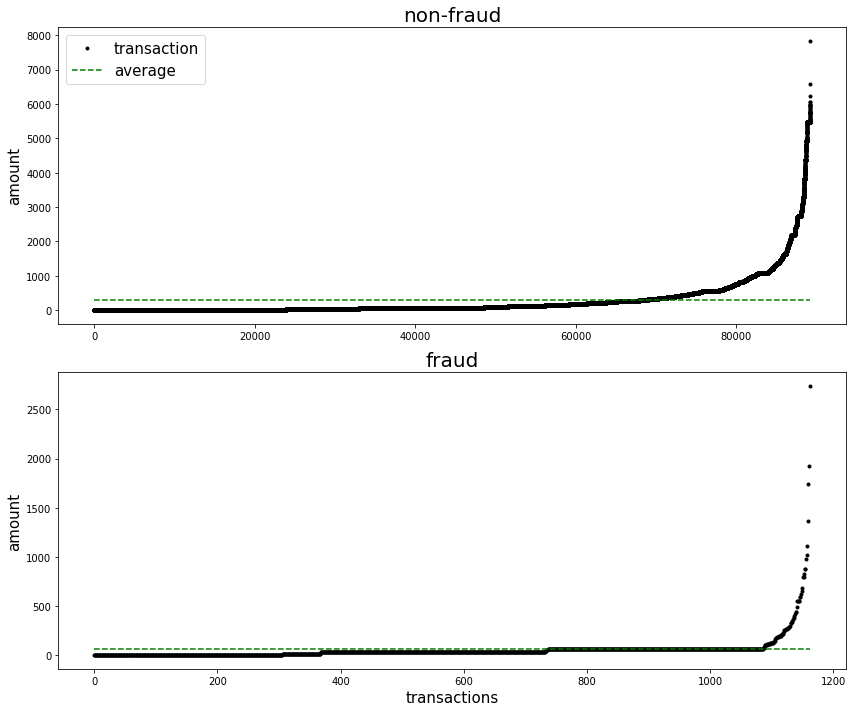

In [26]:
plt.figure(figsize=(12, 10))
plt_idx = 1
for d in datasets:
    plt.subplot(2, 1, plt_idx)
    min_amount = min(d['Amount'])
    max_amount = max(d['Amount'])
    plt.plot(range(d.shape[0]), np.sort(d['Amount']), 'k.', label='transaction')
#     plt.plot(date_num, amount, 'k.', label='num trans.')
    plt.plot(np.linspace(0, d.shape[0], 100), np.zeros(100)+np.mean(d['Amount']), 'g--',label='average')
    plt_idx += 1
    plt.title(d.name, size=20)
    plt.ylabel('amount', size=15)
    if plt_idx == 3:
        plt.xlabel('transactions', size=15)
    else:
        plt.legend(fontsize=15)
plt.tight_layout()
plt.savefig(join(utils_data.FOLDER_REAL_DATA_ANALYSIS, 'amount_day-in-year'))
plt.show()

For each merchant, we will have a probability distribution over the amount spent

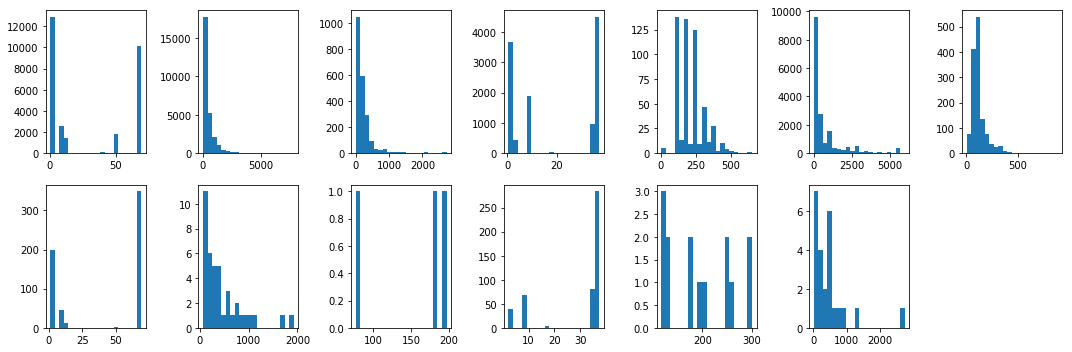

In [27]:
from scipy.optimize import curve_fit

def sigmoid(x, x0, k):
    y = 1 / (1 + np.exp(-k * (x - x0)))
    return y

num_merchants = data_stats.loc['num merchants', 'all']
num_bins = 20
merchant_amount_distr = np.zeros((2, num_merchants, 2*num_bins+1))

plt.figure(figsize=(15, 5))
plt_idx = 1
for dataset in [dataset0, dataset1]:
    for m in dataset0['MerchantID'].unique():
        
        # get all transactions from this merchant
        trans_merch = dataset.loc[dataset['MerchantID']==m]
        num_transactions = trans_merch.shape[0]
        
        if num_transactions > 0:

            # get the amounts paid for the transactions with this merchant
            amounts = trans_merch['Amount']
            bins_height, bins_edges = np.histogram(amounts, bins=num_bins)
            bins_height = np.array(bins_height, dtype=np.float)
            bins_height /= np.sum(bins_height)
            
            merchant_amount_distr[int(plt_idx > 7), (plt_idx-1)%7, :] = np.concatenate((bins_height, bins_edges))
            
            plt.subplot(2, num_merchants, plt_idx)
            plt.hist(amounts, bins=num_bins)
            
        plt_idx += 1
        
plt.tight_layout()
plt.show()

np.save(join(utils_data.FOLDER_SIMULATOR_INPUT,'merchant_amount_distr'), merchant_amount_distr)

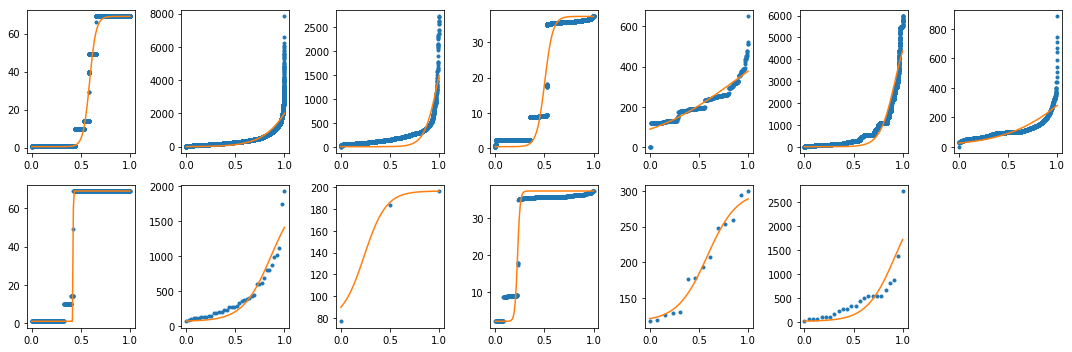

[[[  5.00000000e-01   6.90000000e+01   5.89532805e-01   3.04891437e+01]
  [  7.50000000e-01   7.83556000e+03   1.17433352e+00   6.10730096e+00]
  [  1.00000000e+00   2.72415000e+03   9.87533463e-01   1.44727841e+01]
  [  4.40000000e-01   3.73700000e+01   5.03326047e-01   2.43485948e+01]
  [  1.19000000e+00   6.49830000e+02   8.52669716e-01   2.18402073e+00]
  [  8.80000000e-01   5.96501000e+03   9.21352597e-01   1.30519161e+01]
  [  9.00000000e-01   8.85710000e+02   1.27179978e+00   2.81563241e+00]]

 [[  1.00000000e+00   6.90000000e+01   4.22375397e-01   1.05466640e+03]
  [  6.70000000e+01   1.92800000e+03   8.63242219e-01   6.92154629e+00]
  [  7.68500000e+01   1.96550000e+02   2.36976775e-01   8.92367388e+00]
  [  2.20000000e+00   3.73700000e+01   2.25628136e-01   7.59846774e+01]
  [  1.17230000e+02   2.99750000e+02   5.83883890e-01   6.59824501e+00]
  [  1.34800000e+01   2.73702000e+03   9.24234929e-01   6.91762983e+00]
  [  0.00000000e+00   0.00000000e+00   0.00000000e+00   0.0000

In [28]:
from scipy.optimize import curve_fit

def sigmoid(x, x0, k):
    y = 1 / (1 + np.exp(-k * (x - x0)))
    return y

num_merchants = data_stats.loc['num merchants', 'all']
merchant_amount_parameters = np.zeros((2, num_merchants, 4))

plt.figure(figsize=(15, 5))
plt_idx = 1
for dataset in [dataset0, dataset1]:
    for m in dataset0['MerchantID'].unique():
        
        # get all transactions from this merchant
        trans_merch = dataset.loc[dataset['MerchantID']==m]
        num_transactions = trans_merch.shape[0]
        
        if num_transactions > 0:

            # get the amounts paid for the transactions with this merchant
            amounts = np.sort(trans_merch['Amount']) 
            min_amount = min(amounts)
            max_amount = max(amounts)
            amounts_normalised = (amounts - min_amount) / (max_amount - min_amount)

            plt.subplot(2, num_merchants, plt_idx)
            plt.plot(np.linspace(0, 1, num_transactions), amounts, '.')
            
            # fit sigmoid
            x_vals = np.linspace(0, 1, 100)
            try:
                p_sigmoid, _ = curve_fit(sigmoid, np.linspace(0, 1, num_transactions), amounts_normalised)
                amounts_predict = sigmoid(x_vals, *p_sigmoid)
                amounts_predict_denormalised = amounts_predict * (max_amount - min_amount) + min_amount
                plt.plot(x_vals, amounts_predict_denormalised)
            except:
                # fit polynomial
                p_poly = np.polyfit(np.linspace(0, 1, num_transactions), amounts_normalised, 2)
                amounts_predict = np.polyval(p_poly, x_vals)
                p_sigmoid, _ = curve_fit(sigmoid, x_vals, amounts_predict)
                amounts_predict = sigmoid(x_vals, *p_sigmoid)
                amounts_predict_denormalised = amounts_predict * (max_amount - min_amount) + min_amount
                plt.plot(x_vals, amounts_predict_denormalised)

            merchant_amount_parameters[int(plt_idx > 7), (plt_idx-1)%7] = [min_amount, max_amount, p_sigmoid[0], p_sigmoid[1]]
     
        plt_idx += 1
        
plt.tight_layout()
plt.show()

np.save(join(utils_data.FOLDER_SIMULATOR_INPUT,'merchant_amount_parameters'), merchant_amount_parameters)
print(merchant_amount_parameters)

We conclude that the normal customers and fraudsters follow roughly the same distribution, so we will only have one per merchant; irrespective of whether a genuine or fraudulent customer is making the transaction.

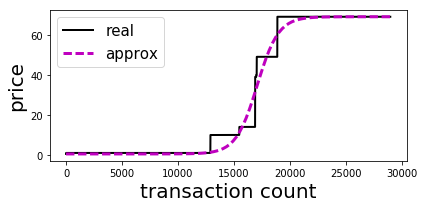

In [29]:
from scipy.optimize import curve_fit

def sigmoid(x, x0, k):
    y = 1 / (1 + np.exp(-k * (x - x0)))
    return y

num_merchants = data_stats.loc['num merchants', 'all']
merchant_amount_parameters = np.zeros((2, num_merchants, 4))

plt.figure(figsize=(6, 3))
plt_idx = 1
dataset  = dataset0
m = dataset0['MerchantID'].unique()[0]
        
# get all transactions from this merchant
trans_merch = dataset.loc[dataset['MerchantID']==m]
num_transactions = trans_merch.shape[0]
        

# get the amounts paid for the transactions with this merchant
amounts = np.sort(trans_merch['Amount']) 
min_amount = min(amounts)
max_amount = max(amounts)
amounts_normalised = (amounts - min_amount) / (max_amount - min_amount)

plt.plot(range(num_transactions), amounts, 'k-', linewidth=2, label='real')

# fit sigmoid
x_vals = np.linspace(0, 1, 100)
x = np.linspace(0, 1, num_transactions)
p_sigmoid, _ = curve_fit(sigmoid, np.linspace(0, 1, num_transactions), amounts_normalised)
amounts_predict = sigmoid(x_vals, *p_sigmoid)
amounts_predict_denormalised = amounts_predict * (max_amount - min_amount) + min_amount
plt.plot(np.linspace(0, num_transactions, 100), amounts_predict_denormalised, 'm--', linewidth=3, label='approx')

merchant_amount_parameters[int(plt_idx > 7), (plt_idx-1)%7] = [min_amount, max_amount, p_sigmoid[0], p_sigmoid[1]]

plt.xlabel('transaction count', fontsize=20)
plt.ylabel('price', fontsize=20)

plt.legend(fontsize=15)
plt.tight_layout()
plt.savefig(join(utils_data.FOLDER_REAL_DATA_ANALYSIS, 'merchant_price_sigmoid_fit'))
plt.show()

## Customers

Here we want to find out how long customers/fraudsters return, i.e., how often the same credit card is used over time.

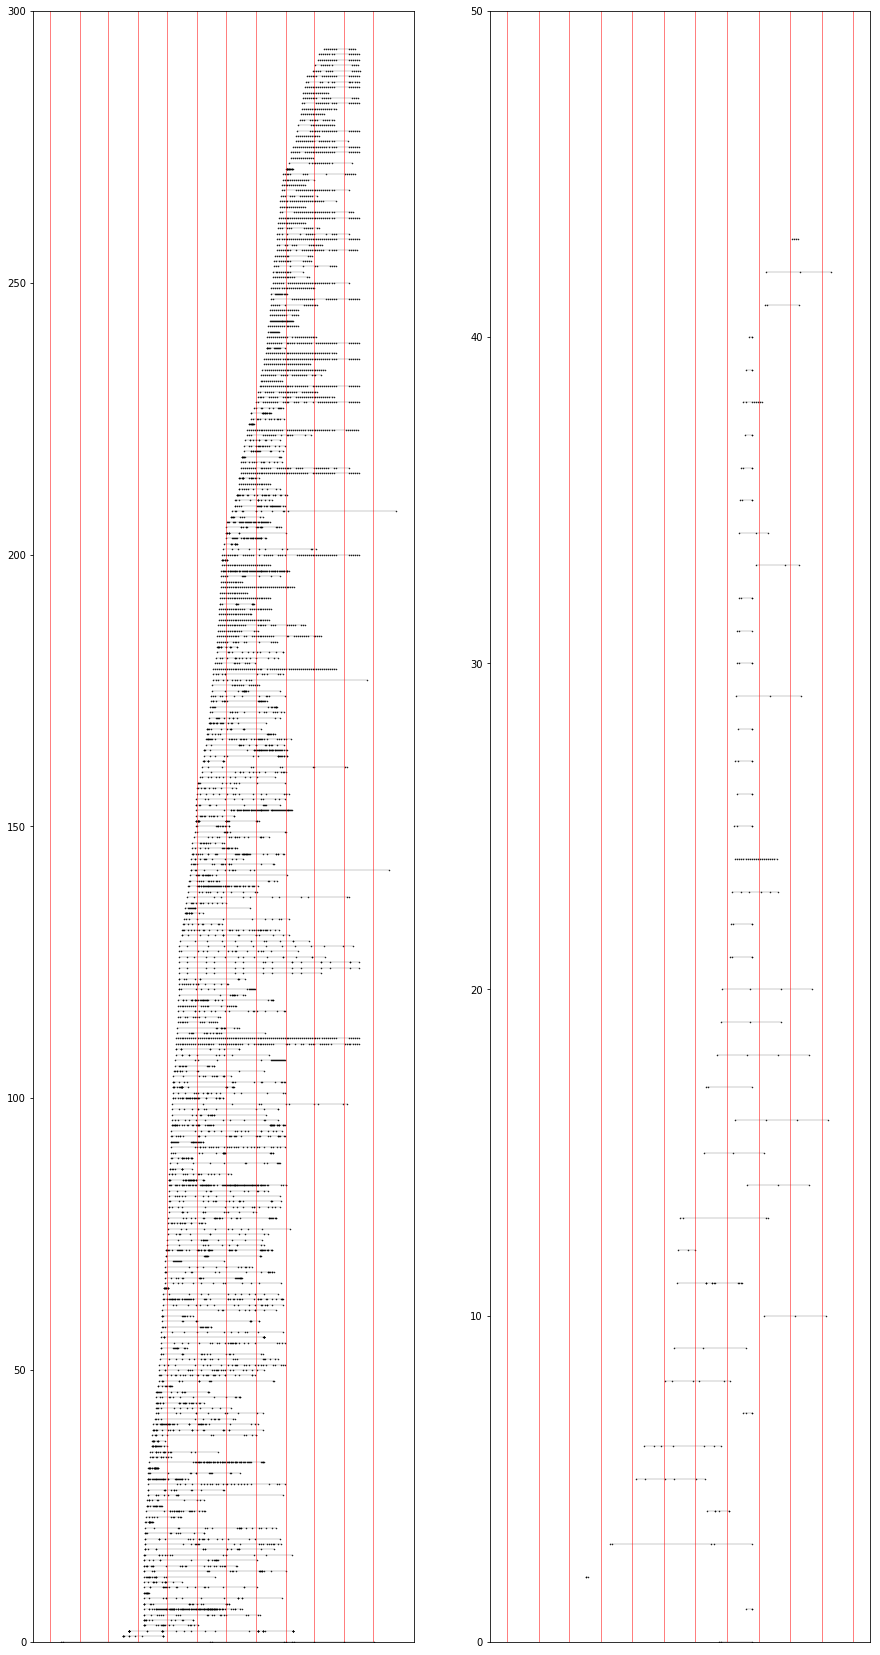

In [30]:
plt.figure(figsize=(15, 30))
plt_idx = 1
dist_transactions = [[], []]
for d in datasets:
#     d = d.loc[d['Date'].apply(lambda date: date.month) < 7]
#     d = d.loc[d['Date'].apply(lambda date: date.month) > 3]
    plt.subplot(1, 2, plt_idx)
    trans_idx = 0
    for card in dataset01['CardID'].unique():
        card_times = d.loc[d['CardID'] == card, 'Global_Date']
        dist_transactions[plt_idx-1].extend([(card_times.iloc[i+1] - card_times.iloc[i]).days for i in range(len(card_times)-1)])
        if plt_idx == 2:
            num_c = 2
        else:
            num_c = 10
        if len(card_times) > num_c:
            card_times = card_times.apply(lambda date: date.date())
            card_times = matplotlib.dates.date2num(card_times)
            plt.plot(card_times, np.zeros(len(card_times)) + trans_idx, 'k.', markersize=1)
            plt.plot(card_times, np.zeros(len(card_times)) + trans_idx, 'k-', linewidth=0.2)
            trans_idx += 1
    min_date = matplotlib.dates.date2num(min(dataset01['Global_Date']).date())
    max_date = matplotlib.dates.date2num(max(dataset01['Global_Date']).date())
#     plt.xlim([min_date, max_date])
    plt.xticks([])
    for m in range(1,13):
        datenum = matplotlib.dates.date2num(datetime(2016, m, 1))
        plt.plot(np.zeros(2)+datenum, [-1, 1000], 'r-', linewidth=0.5)
    if plt_idx == 1:
        plt.ylim([0,300])
    else:
        plt.ylim([0, 50])
    plt_idx += 1
plt.show()

In [31]:
# average distance between two transactions with the same card
print(np.mean(dist_transactions[0]))
print(np.mean(dist_transactions[1]))

12.9877356607
8.94230769231


At a given transaction, estimate the probability of doing another transaction with the same card.

In [32]:
prob_stay = np.zeros(2)
for k in range(2):

    dataset = [dataset0, dataset1][k]
    
    creditcards = dataset.loc[dataset['Global_Date'].apply(lambda d: d.month) > 3]
    creditcards = creditcards.loc[creditcards['Global_Date'].apply(lambda d: d.month) < 6]
    creditcard_counts = creditcards['CardID'].value_counts()
    creditcardIDs = creditcards['CardID']

    data = dataset.loc[dataset['Global_Date'].apply(lambda d: d.month) > 3]

    single = 0
    multi = 0
    for i in range(len(creditcards)):
        cc = creditcards.iloc[i]['CardID']
        dd = creditcards.iloc[i]['Global_Date']
        cond1 = data['CardID'] == cc
        cond2 = data['Global_Date'] > dd
        if len(data.loc[np.logical_and(cond1, cond2)]) == 0:
            single += 1
        else:
            multi += 1
    
    prob_stay[k] = multi/(single+multi)

    print('probability of doing another transaction:', prob_stay[k], '{}'.format(['non-fraud', 'fraud'][k]))
    
np.save(join(utils_data.FOLDER_SIMULATOR_INPUT, 'prob_stay'), prob_stay)

probability of doing another transaction: 0.516122082585 non-fraud
probability of doing another transaction: 0.333333333333 fraud


## Fraud behaviour

In [33]:
cards0 = dataset0['CardID'].unique()
cards1 = dataset1['CardID'].unique()

print('cards total:', len(np.union1d(cards0, cards1)))
print('fraud cards:', len(cards1))
print('intersection:', len(np.intersect1d(cards0, cards1)))

# go through the cards that were in both sets
cards0_1 = []
cards1_0 = []
cards010 = []
for cib in np.intersect1d(cards0, cards1):
    date0 = dataset0.loc[dataset0['CardID']==cib].iloc[0]['Global_Date']
    date1 = dataset1.loc[dataset1['CardID']==cib].iloc[0]['Global_Date']
    if date0 < date1:
        cards0_1.append(cib)
        # genuine purchases after fraud
        dates00 = dataset0.loc[dataset0['CardID']==cib].iloc[1:]['Global_Date']
        if len(dates00)>0:
            if sum(dates00>date1)>0:
                cards010.append(cib)
    else:
        cards1_0.append(cib)
        
print('first genuine then fraud: ', len(cards0_1))
print('first fraud then genuine: ', len(cards1_0))
print('genuine again after fraud: ', len(cards010))

prob_stay_after_fraud = len(cards010)/len(cards0_1)
print('prob of purchase after fraud: ', prob_stay_after_fraud)
np.save(join(utils_data.FOLDER_SIMULATOR_INPUT, 'prob_stay_after_fraud'), prob_stay_after_fraud )

cards total: 54666
fraud cards: 799
intersection: 266
first genuine then fraud:  238
first fraud then genuine:  28
genuine again after fraud:  23
prob of purchase after fraud:  0.09663865546218488


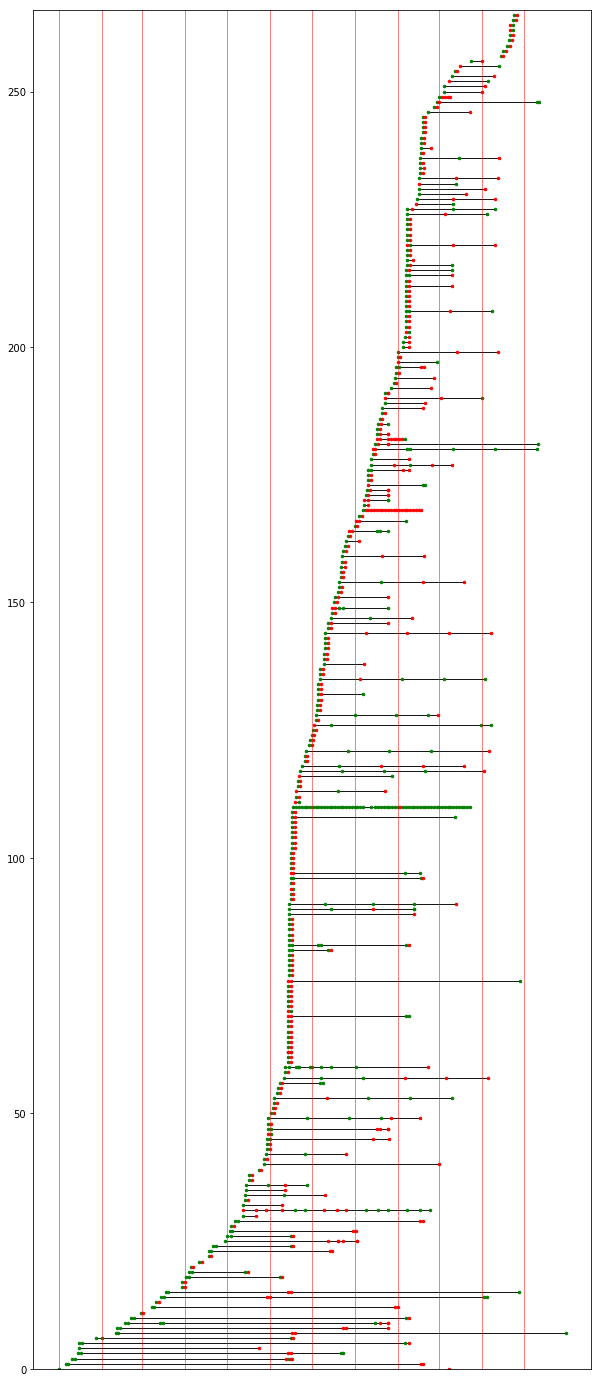

genuine transactions after fraud:  48
fraud is the last transaction:  218


In [34]:
plt.figure(figsize=(10, 25))

dist_transactions = []
trans_idx = 0

data_compromised = dataset01.loc[dataset01['CardID'].apply(lambda cid: cid in np.intersect1d(cards0, cards1))]

no_trans_after_fraud = 0
trans_after_fraud = 0
for card in data_compromised['CardID'].unique():
    cards_used = data_compromised.loc[data_compromised['CardID'] == card, ['Global_Date', 'Target']]
    dist_transactions.extend([(cards_used.iloc[i+1, 0] - cards_used.iloc[i, 0]).days for i in range(len(cards_used)-1)])

    card_times = cards_used['Global_Date'].apply(lambda date: date.date())
    card_times = matplotlib.dates.date2num(card_times)
    plt.plot(card_times, np.zeros(len(card_times)) + trans_idx, 'k-', linewidth=0.9)
    
    cond0 = cards_used['Target'] == 0
    plt.plot(card_times[cond0], np.zeros(len(card_times[cond0])) + trans_idx, 'g.', markersize=5)
    
    cond1 = cards_used['Target'] == 1
    plt.plot(card_times[cond1], np.zeros(len(card_times[cond1])) + trans_idx, 'r.', markersize=5)
    
    if max(cards_used.loc[cards_used['Target']==0, 'Global_Date']) > max(cards_used.loc[cards_used['Target']==1, 'Global_Date']):
        trans_after_fraud += 1
    else:
        no_trans_after_fraud += 1
    
    trans_idx += 1
    
min_date = matplotlib.dates.date2num(min(dataset01['Global_Date']).date())
max_date = matplotlib.dates.date2num(max(dataset01['Global_Date']).date())

plt.xticks([])
plt.ylim([0, trans_idx])

# print lines for months
for m in range(1,13):
    datenum = matplotlib.dates.date2num(datetime(2016, m, 1))
    plt.plot(np.zeros(2)+datenum, [-1, 1000], 'r-', linewidth=0.5)

plt_idx += 1
plt.show()

print("genuine transactions after fraud: ", trans_after_fraud)
print("fraud is the last transaction: ", no_trans_after_fraud)

when a fraudster uses an existing card, are country and currency always the same?

In [35]:
plt.figure(figsize=(10, 25))

dist_transactions = []
trans_idx = 0

for card in data_compromised['CardID'].unique():
    cards_used = data_compromised.loc[data_compromised['CardID'] == card, ['Global_Date', 'Target', 'Country', 'Currency']]
    if len(cards_used['Country'].unique()) > 1 or len(cards_used['Currency'].unique()) > 1:
        print(cards_used)
        print("")

               Global_Date  Target Country Currency
87501  2016-05-28 00:31:05       0      GB      GBP
130560 2016-10-01 13:53:20       1      GB      USD

               Global_Date  Target Country Currency
92670  2016-06-12 23:51:29       0      GB      EUR
94495  2016-06-15 23:43:42       0      GB      EUR
97119  2016-06-20 02:17:36       0      GB      EUR
97550  2016-06-21 14:55:34       0      GB      EUR
97674  2016-06-22 05:08:04       0      GB      EUR
100062 2016-06-30 04:53:27       0      GB      EUR
100468 2016-07-01 02:16:21       0      GB      EUR
102955 2016-07-08 02:57:38       0      GB      EUR
105482 2016-07-15 21:51:13       0      GB      EUR
110268 2016-08-02 10:33:17       0      GB      EUR
128557 2016-09-23 00:13:58       1      GB      USD

               Global_Date  Target Country Currency
101399 2016-07-03 14:16:16       1      DE      GBP
105343 2016-07-15 11:43:08       0      DE      EUR
137910 2016-10-31 14:11:16       0      DE      EUR
139951 201